# 練習使用 Naive Bayes 技術，收集各國股市前日收盤漲跌情形進行台灣股市漲跌的預測

### 因為時間區域不同，各國股市收盤時間是不一樣的，但會有連動的影響，我們可以根據過去歷史紀錄，分析國際股市的連動關聯性並建構談灣股市當日的漲跌狀態，換句話說，可以使用其他國家前一日或是當日正在進行的股市漲跌情形來預測台灣股市當日的股票漲跌的趨勢。此實驗藉由使用  Yahoo! Finance's API 來下載各國股市數據。

## yfinance offers a threaded and Pythonic way to download market data from Yahoo!Ⓡ finance.
## yfinance is not affiliated, endorsed, or vetted by Yahoo, Inc. It's an open-source tool that uses Yahoo's publicly available APIs, and is intended for research and educational purposes.
## https://pypi.org/project/yfinance/

## Naive Bayes classifier Model
<img src="NB_formula.jpg" width="600">

## Naive Bayes classifier for multivariate Bernoulli models.


### 1. GaussianNB -- Gaussian Naive Bayes (GaussianNB).
#### Can perform online updates to model parameters via partial_fit. For details on algorithm used to update feature means and variance online, see Stanford CS tech report STAN-CS-79-773 by Chan, Golub, and LeVeque:
#### http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf
#### 高斯分類器主要用於特徵為連續變數時，比方說特徵長度為幾公分、重量為幾公斤等等。在這個模型下，假設特徵資料服從常態分配。

### 2. MultinomialNB -- Naive Bayes classifier for multinomial models. 
#### The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.
#### 多項式貝氏分類器主要用在離散變數，比方說次數、類別等等。而在個模型中，會多一個 alpha 參數，也就是平滑化的處理。

### 3. BernoulliNB -- Naive Bayes classifier for multivariate Bernoulli models.
#### Like MultinomialNB, this classifier is suitable for discrete data. The difference is that while MultinomialNB works with occurrence counts, BernoulliNB is designed for binary/boolean features.
#### 伯努力貝氏分類器主要適用於二元的特徵，比方說特徵是否出現、特徵大小、特徵長短等等這種二元的分類。

### 4. CategoricalNB -- Naive Bayes classifier for categorical features.
#### The categorical Naive Bayes classifier is suitable for classification with discrete features that are categorically distributed (also called a generalized Bernoulli distribution, multinoulli distribution) ). The categories of each feature are drawn from a categorical distribution.


### 5. ComplementNB -- The Complement Naive Bayes classifier described in Rennie et al. (2003).
#### The Complement Naive Bayes classifier was designed to correct the “severe assumptions” made by the standard Multinomial Naive Bayes classifier. It is particularly suited for imbalanced data sets.

In [2]:
pip install yfinance --upgrade --no-cache-dir

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz  # 使用 pytz 處理 Python的時區問題
import seaborn as sn
import yfinance as yf
import time
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB

# direct timezone cache to use local location
yf.set_tz_cache_location('cache/')

## yfinance: Download market data from Yahoo! Finance's API

yfinance is not affiliated, endorsed, or vetted by Yahoo, Inc. It's an open-source tool that uses Yahoo's publicly available APIs, and is intended for research and educational purposes.

https://github.com/ranaroussi/yfinance

參考連結 Yahoo! Finance Global Indices：https://finance.yahoo.com/world-indices  
參考連結 Apple Inc. (AAPL) https://finance.yahoo.com/quote/AAPL?p=AAPL&.tsrc=fin-srch

In [157]:
# Example of downloading APPle Inc. historical stock data
# Using "download"  method -->  yf.download(ticker, start = start, end=end, progress=Fasle)
aapl_df = yf.download(
    'AAPL', start='2023-01-01', end='2023-12-31', progress=False,
)

# Plot the close price of the AAPL
aapl_df['Adj Close'].plot(title="APPLE's stock price in 2023")
plt.show()
aapl_df.tail()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-12-22  195.179993  195.410004  192.970001  193.600006  193.353287   
2023-12-26  193.610001  193.889999  192.830002  193.050003  192.803986   
2023-12-27  192.490005  193.500000  191.089996  193.149994  192.903839   
2023-12-28  194.139999  194.660004  193.169998  193.580002  193.333298   
2023-12-29  193.899994  194.399994  191.729996  192.529999  192.284637   

              Volume  
Date                  
2023-12-22  37122800  
2023-12-26  28919300  
2023-12-27  48087700  
2023-12-28  34049900  
2023-12-29  42628800

[*********************100%%**********************]  1 of 1 completed


Open      High       Low     Close  Adj Close      Volume
Date                                                                     
1997-05-15  0.121875  0.125000  0.096354  0.097917   0.097917  1443120000
1997-05-16  0.098438  0.098958  0.085417  0.086458   0.086458   294000000
1997-05-19  0.088021  0.088542  0.081250  0.085417   0.085417   122136000
1997-05-20  0.086458  0.087500  0.081771  0.081771   0.081771   109344000
1997-05-21  0.081771  0.082292  0.068750  0.071354   0.071354   377064000

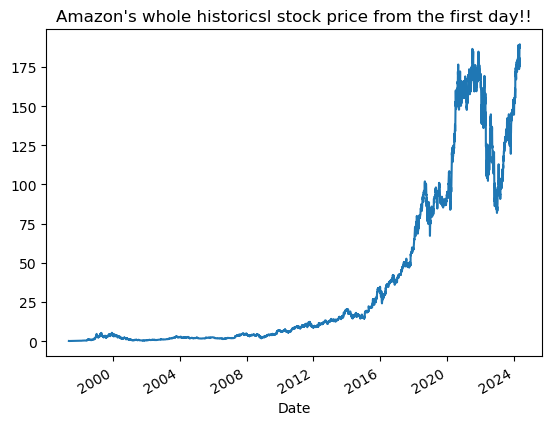

In [148]:
# If not specifically assigned the starting and ending dates, it will download whole dataset of the ticker, form 1980-12-12 to today!)
amzn_df = yf.download('AMZN')
plt.show()
amzn_df['Close'].plot(title="Amazon's whole historicsl stock price from the first day!!")
amzn_df.head()
# For Amazon company -->  from 1997/05/15 - 2024/05/10

In [158]:
# Want data for the most recent trading days
recent_data = yf.download("AAPL", period="5d")
print(recent_data)

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-05-06  182.350006  184.199997  180.419998  181.710007  181.463882   
2024-05-07  183.449997  184.899994  181.320007  182.399994  182.152924   
2024-05-08  182.850006  183.070007  181.449997  182.740005  182.492477   
2024-05-09  182.559998  184.660004  182.110001  184.570007  184.320007   
2024-05-10  184.899994  185.089996  182.130005  183.050003  183.050003   

              Volume  
Date                  
2024-05-06  78569700  
2024-05-07  77305800  
2024-05-08  45057100  
2024-05-09  48983000  
2024-05-10  50727400  


In [160]:
# Fetching Data for Multiple Tickers
# Retrieve data for multiple stocks simueltaneously
multi_data = yf.download(["AAPL", "MSFT"], start="2023-01-01", end="2023-12-31")
print(multi_data)

[*********************100%%**********************]  2 of 2 completed

Price        Adj Close                   Close                    High  \
Ticker            AAPL        MSFT        AAPL        MSFT        AAPL   
Date                                                                     
2023-01-03  124.216293  237.036026  125.070000  239.580002  130.899994   
2023-01-04  125.497498  226.667297  126.360001  229.100006  128.660004   
2023-01-05  124.166641  219.949371  125.019997  222.309998  127.769997   
2023-01-06  128.735229  222.541565  129.619995  224.929993  130.289993   
2023-01-09  129.261627  224.708313  130.149994  227.119995  133.410004   
...                ...         ...         ...         ...         ...   
2023-12-22  193.353287  373.888580  193.600006  374.579987  195.410004   
2023-12-26  192.803986  373.968445  193.050003  374.660004  193.889999   
2023-12-27  192.903839  373.379547  193.149994  374.070007  193.500000   
2023-12-28  193.333298  374.587280  193.580002  375.279999  194.660004   
2023-12-29  192.284637  375.345886  19

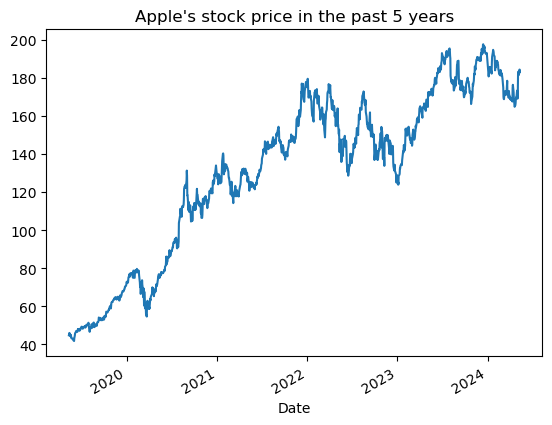

Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-05-06  182.350006  184.199997  180.419998  181.710007  181.463882   
2024-05-07  183.449997  184.899994  181.320007  182.399994  182.152924   
2024-05-08  182.850006  183.070007  181.449997  182.740005  182.492477   
2024-05-09  182.559998  184.660004  182.110001  184.570007  184.320007   
2024-05-10  184.899994  185.089996  182.130005  183.050003  183.050003   

              Volume  
Date                  
2024-05-06  78569700  
2024-05-07  77305800  
2024-05-08  45057100  
2024-05-09  48983000  
2024-05-10  50727400

In [149]:
# Example for ploting Apple stock trend in the past 5 years
# Using "Ticker" module to assign one specific ticker , and use "hostory()"" method to access ticker data in a more Pythonic way.
tickerData = yf.Ticker('AAPL')
aapl_df_5y = tickerData.history(period="5y")
aapl_df_5y['Close'].plot(title="Apple's stock price in the past 5 years")
plt.show()
aapl_df.tail()

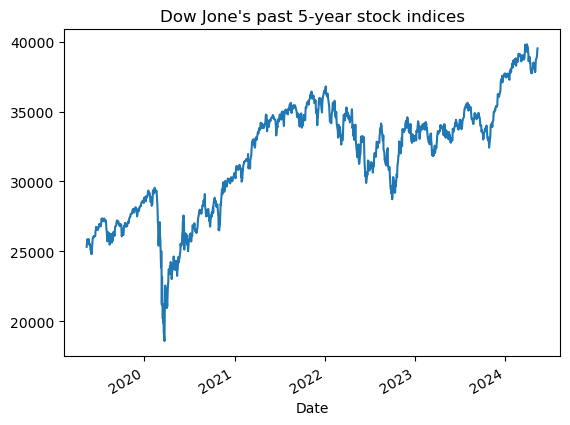

Open          High           Low  \
Date                                                                  
2024-05-06 00:00:00-04:00  38762.429688  38886.468750  38689.378906   
2024-05-07 00:00:00-04:00  38858.941406  38977.609375  38840.398438   
2024-05-08 00:00:00-04:00  38818.898438  39094.738281  38814.988281   
2024-05-09 00:00:00-04:00  39064.269531  39413.660156  38988.851562   
2024-05-10 00:00:00-04:00  39466.519531  39579.878906  39406.261719   

                                  Close     Volume  Dividends  Stock Splits  
Date                                                                         
2024-05-06 00:00:00-04:00  38852.269531  315550000        0.0           0.0  
2024-05-07 00:00:00-04:00  38884.261719  360930000        0.0           0.0  
2024-05-08 00:00:00-04:00  39056.390625  292340000        0.0           0.0  
2024-05-09 00:00:00-04:00  39387.761719  303270000        0.0           0.0  
2024-05-10 00:00:00-04:00  39512.839844  289480000        0.0           0.0

In [153]:
# ^DJI is the symbol of Dow Jones Industrial Average in Yahoo! Finance
tickerData = yf.Ticker('^DJI')
DJI_df_5y = tickerData.history(period="5y")
DJI_df_5y['Close'].plot(title="Dow Jone's past 5-year stock indices")
plt.show()
DJI_df_5y.tail()

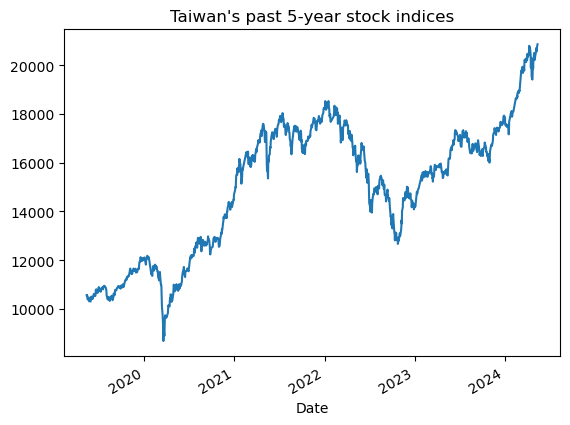

Open          High           Low  \
Date                                                                  
2024-05-07 00:00:00+08:00  20634.619141  20689.189453  20493.800781   
2024-05-08 00:00:00+08:00  20604.179688  20700.509766  20547.480469   
2024-05-09 00:00:00+08:00  20710.050781  20754.609375  20560.769531   
2024-05-10 00:00:00+08:00  20582.119141  20765.820312  20574.009766   
2024-05-13 00:00:00+08:00  20905.160156  20933.279297  20816.419922   

                                  Close   Volume  Dividends  Stock Splits  
Date                                                                       
2024-05-07 00:00:00+08:00  20653.529297  4547600        0.0           0.0  
2024-05-08 00:00:00+08:00  20700.509766  4479700        0.0           0.0  
2024-05-09 00:00:00+08:00  20560.769531  4326400        0.0           0.0  
2024-05-10 00:00:00+08:00  20708.839844  5206400        0.0           0.0  
2024-05-13 00:00:00+08:00  20857.710938        0        0.0           0.0

In [154]:
# ^TWII is the symbol of Taiwan Stock in Yahoo! Finance
tickerData = yf.Ticker('^TWII')
TWII = tickerData.history(period="5y")
TWII['Close'].plot(title="Taiwan's past 5-year stock indices")
plt.show()
TWII.tail()

## 一次讀取多家公司的股市資料  (yf.Tickers)

In [161]:
# To initialize multiple Ticker objects
data_multiple = yf.Tickers('MSFT AAPL GOOG')
data_multiple.tickers['MSFT'].info

{'address1': 'One Microsoft Way',
 'city': 'Redmond',
 'state': 'WA',
 'zip': '98052-6399',
 'country': 'United States',
 'phone': '425 882 8080',
 'website': 'https://www.microsoft.com',
 'industry': 'Software - Infrastructure',
 'industryKey': 'software-infrastructure',
 'industryDisp': 'Software - Infrastructure',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Microsoft Corporation develops and supports software, services, devices and solutions worldwide. The Productivity and Business Processes segment offers office, exchange, SharePoint, Microsoft Teams, office 365 Security and Compliance, Microsoft viva, and Microsoft 365 copilot; and office consumer services, such as Microsoft 365 consumer subscriptions, Office licensed on-premises, and other office services. This segment also provides LinkedIn; and dynamics business solutions, including Dynamics 365, a set of intelligent, cloud-based applications across ERP, CRM, power 

In [162]:
data_multiple.tickers['MSFT'].history(period="1mo")

Open        High         Low       Close  \
Date                                                                        
2024-04-11 00:00:00-04:00  425.820007  429.369995  422.359985  427.929993   
2024-04-12 00:00:00-04:00  424.049988  425.179993  419.769989  421.899994   
2024-04-15 00:00:00-04:00  426.600006  426.820007  413.429993  413.640015   
2024-04-16 00:00:00-04:00  414.570007  418.399994  413.730011  414.579987   
2024-04-17 00:00:00-04:00  417.250000  418.880005  410.329987  411.839996   
2024-04-18 00:00:00-04:00  410.630005  411.890015  403.950012  404.269989   
2024-04-19 00:00:00-04:00  404.029999  405.480011  397.769989  399.119995   
2024-04-22 00:00:00-04:00  400.079987  402.850006  395.750000  400.959991   
2024-04-23 00:00:00-04:00  404.239990  408.200012  403.059998  407.570007   
2024-04-24 00:00:00-04:00  409.559998  412.470001  406.779999  409.059998   
2024-04-25 00:00:00-04:00  394.029999  399.890015  388.029999  399.040009   
2024-04-26 00:00:00-04:00  412.170013  413.000000  405.760010  406.320007   
2024-04-29 00:00:00-04:00  405.250000  406.320007  399.190002  402.250000   
2024-04-30 00:00:00-04:00  401.489990  402.160004  389.170013  389.329987   
2024-05-01 00:00:00-04:00  392.609985  401.720001  390.309998  394.940002   
2024-05-02 00:00:00-04:00  397.660004  399.929993  394.649994  397.839996   
2024-05-03 00:00:00-04:00  402.279999  407.149994  401.859985  406.660004   
2024-05-06 00:00:00-04:00  408.760010  413.929993  406.369995  413.540009   
2024-05-07 00:00:00-04:00  414.660004  414.670013  409.089996  409.339996   
2024-05-08 00:00:00-04:00  408.170013  412.230011  406.709991  410.540009   
2024-05-09 00:00:00-04:00  410.570007  412.720001  409.100006  412.320007   
2024-05-10 00:00:00-04:00  412.940002  415.380005  411.799988  414.739990   

                             Volume  Dividends  Stock Splits  
Date                                                          
2024-04-11 00:00:00-04:00  17966400        0.0           0.0  
2024-04-12 00:00:00-04:00  19232100        0.0           0.0  
2024-04-15 00:00:00-04:00  20273500        0.0           0.0  
2024-04-16 00:00:00-04:00  16765600        0.0           0.0  
2024-04-17 00:00:00-04:00  15855500        0.0           0.0  
2024-04-18 00:00:00-04:00  21029900        0.0           0.0  
2024-04-19 00:00:00-04:00  30276500        0.0           0.0  
2024-04-22 00:00:00-04:00  20286900        0.0           0.0  
2024-04-23 00:00:00-04:00  15734500        0.0           0.0  
2024-04-24 00:00:00-04:00  15065300        0.0           0.0  
2024-04-25 00:00:00-04:00  40586500        0.0           0.0  
2024-04-26 00:00:00-04:00  29694700        0.0           0.0  
2024-04-29 00:00:00-04:00  19582100        0.0           0.0  
2024-04-30 00:00:00-04:00  28781400        0.0           0.0  
2024-05-01 00:00:00-04:00  23562500        0.0           0.0  
2024-05-02 00:00:00-04:00  17709400        0.0           0.0  
2024-05-03 00:00:00-04:00  17446700        0.0           0.0  
2024-05-06 00:00:00-04:00  16996600        0.0           0.0  
2024-05-07 00:00:00-04:00  20018200        0.0           0.0  
2024-05-08 00:00:00-04:00  11792300        0.0           0.0  
2024-05-09 00:00:00-04:00  14689700        0.0           0.0  
2024-05-10 00:00:00-04:00  13395400        0.0           0.0

## 一次比較及呈現多家公司的股市資料趨勢圖

In [163]:
Three_Comp = data_multiple.history(period="1y")
Three_Comp['Close'].plot(title="Microsoft/Google/Apple past 1-year stock indices")

[*********************100%%**********************]  3 of 3 completed


<Axes: title={'center': 'Microsoft/Google/Apple past 1-year stock indices'}, xlabel='Date'>

## 讀入股市資料並進行資料清理

### 讀取國際股市漲跌資料及資料清理的詳細資訊請參考第八次實習的內容


In [164]:
def read(
    symbol: str,
    period: str = '1y',
    interval: str = '1d',
) -> pd.Series:
    ticker = yf.Ticker(symbol)
    history = ticker.history(period=period, interval=interval)

    # attach timezone information on dates
    # tz = pytz.timezone(ticker.info['exchangeTimezoneName'])
    # history.index = history.index.tz_localize(tz)

    return history['Close'].rename(symbol)

In [175]:
# timezone are attached
# UTC+8
display(read('^TWII'))

# UTC-4
display(read('AAPL'))

Date
2023-05-15 00:00:00+08:00    15475.049805
2023-05-16 00:00:00+08:00    15673.900391
2023-05-17 00:00:00+08:00    15925.290039
2023-05-18 00:00:00+08:00    16101.879883
2023-05-19 00:00:00+08:00    16174.919922
                                 ...     
2024-05-07 00:00:00+08:00    20653.529297
2024-05-08 00:00:00+08:00    20700.509766
2024-05-09 00:00:00+08:00    20560.769531
2024-05-10 00:00:00+08:00    20708.839844
2024-05-13 00:00:00+08:00    20857.710938
Name: ^TWII, Length: 243, dtype: float64

Date
2023-05-11 00:00:00-04:00    172.593399
2023-05-12 00:00:00-04:00    171.658386
2023-05-15 00:00:00-04:00    171.161011
2023-05-16 00:00:00-04:00    171.161011
2023-05-17 00:00:00-04:00    171.777740
                                ...    
2024-05-06 00:00:00-04:00    181.463882
2024-05-07 00:00:00-04:00    182.152924
2024-05-08 00:00:00-04:00    182.492477
2024-05-09 00:00:00-04:00    184.320007
2024-05-10 00:00:00-04:00    183.050003
Name: AAPL, Length: 252, dtype: float64

In [176]:
symbols = [
    '^AORD',
    '^AXJO',
    '^BFX',
    '^BSESN',
    '^BUK100P',
    '^BVSP',
    '^DJI',
    '^FCHI',
    '^GDAXI',
    '^GSPC',
    '^GSPTSE',
    '^HSI',
    '^JKSE',
    '^KS11',
    '^MXX',
    '^N225',
    '^NYA',
    '^NZ50',
    '^RUT',
    '^STOXX50E',
    '^TWII',
    '^XAX',
]

# takes about 5 minutes to download these 24 global indices within a year
results = []
for symbol in symbols:
    result = read(symbol, period='1y', interval='1d')

    # convert timezone into 'Asia/Taipei'
    result.index = result.index.tz_convert(pytz.timezone('Asia/Taipei'))
    # remain only date information
    result.index = result.index.date
    
    results.append(result)

# column_names=["Date", symbols]   
# print(column_names)

history = pd.concat(results, axis='columns')
history

^AORD        ^AXJO         ^BFX        ^BSESN    ^BUK100P  \
2023-05-14  7460.500000  7267.100098          NaN           NaN         NaN   
2023-05-15  7424.100098  7234.700195  3750.080078  62345.710938  777.260010   
2023-05-16  7389.299805  7199.200195  3688.889893  61932.468750  774.979980   
2023-05-17  7427.000000  7236.799805  3681.500000  61560.640625  771.739990   
2023-05-18  7471.500000  7279.500000  3717.300049  61431.738281  774.070007   
...                 ...          ...          ...           ...         ...   
2023-06-11          NaN          NaN          NaN           NaN         NaN   
2023-12-25          NaN          NaN          NaN           NaN         NaN   
2024-03-31          NaN          NaN          NaN           NaN         NaN   
2023-12-24          NaN          NaN          NaN           NaN         NaN   
2024-03-29          NaN          NaN          NaN           NaN         NaN   

               ^BVSP          ^DJI        ^FCHI        ^GDAXI        ^GSPC  \
2023-05-14       NaN           NaN          NaN           NaN          NaN   
2023-05-15  109029.0  33348.601562  7418.209961  15917.240234  4136.279785   
2023-05-16  108194.0  33012.140625  7406.009766  15897.929688  4109.899902   
2023-05-17  109460.0  33420.769531  7399.439941  15951.299805  4158.770020   
2023-05-18  110108.0  33535.910156  7446.890137  16163.360352  4198.049805   
...              ...           ...          ...           ...          ...   
2023-06-11       NaN           NaN          NaN           NaN          NaN   
2023-12-25       NaN           NaN          NaN           NaN          NaN   
2024-03-31       NaN           NaN          NaN           NaN          NaN   
2023-12-24       NaN           NaN          NaN           NaN          NaN   
2024-03-29       NaN           NaN          NaN           NaN          NaN   

            ...        ^JKSE        ^KS11          ^MXX         ^N225  \
2023-05-14  ...          NaN  2479.350098           NaN  29626.339844   
2023-05-15  ...  6711.740234  2480.239990  55261.421875  29842.990234   
2023-05-16  ...  6676.563965  2494.659912  55180.968750  30093.589844   
2023-05-17  ...  6663.113770  2515.399902  55067.371094  30573.929688   
2023-05-18  ...          NaN  2537.790039  55263.109375  30808.349609   
...         ...          ...          ...           ...           ...   
2023-06-11  ...          NaN  2629.350098           NaN  32434.000000   
2023-12-25  ...          NaN  2602.590088           NaN  33305.851562   
2024-03-31  ...          NaN  2747.860107           NaN  39803.089844   
2023-12-24  ...          NaN          NaN           NaN  33254.031250   
2024-03-29  ...          NaN          NaN           NaN           NaN   

                    ^NYA         ^NZ50         ^RUT    ^STOXX50E  \
2023-05-14           NaN  11937.599609          NaN          NaN   
2023-05-15  15322.559570  11945.870117  1761.550049  4316.410156   
2023-05-16  15129.250000  11951.660156  1736.180054  4315.509766   
2023-05-17  15313.919922  11974.169922  1774.500000  4323.229980   
2023-05-18  15345.429688  12099.740234  1784.859985          NaN   
...                  ...           ...          ...          ...   
2023-06-11           NaN  11615.549805          NaN          NaN   
2023-12-25           NaN           NaN          NaN          NaN   
2024-03-31           NaN           NaN          NaN          NaN   
2023-12-24           NaN           NaN          NaN          NaN   
2024-03-29           NaN           NaN          NaN          NaN   

                   ^TWII         ^XAX  
2023-05-14           NaN          NaN  
2023-05-15  15475.049805  4013.120117  
2023-05-16  15673.900391  3911.790039  
2023-05-17  15925.290039  3937.270020  
2023-05-18  16101.879883  3936.100098  
...                  ...          ...  
2023-06-11           NaN          NaN  
2023-12-25  17604.839844          NaN  
2024-03-31           NaN          NaN  
2023-12-24           NaN          NaN 

In [177]:
# 使用 Pickle 模組保存資料，壓縮資料、保存、並隨時隨地解開儲存好的資料，還原工作階段
history.to_pickle('history.pkl.zip')

In [178]:
history = pd.read_pickle('history.pkl.zip')

In [179]:
history.head()

^AORD        ^AXJO         ^BFX        ^BSESN    ^BUK100P  \
2023-05-14  7460.500000  7267.100098          NaN           NaN         NaN   
2023-05-15  7424.100098  7234.700195  3750.080078  62345.710938  777.260010   
2023-05-16  7389.299805  7199.200195  3688.889893  61932.468750  774.979980   
2023-05-17  7427.000000  7236.799805  3681.500000  61560.640625  771.739990   
2023-05-18  7471.500000  7279.500000  3717.300049  61431.738281  774.070007   

               ^BVSP          ^DJI        ^FCHI        ^GDAXI        ^GSPC  \
2023-05-14       NaN           NaN          NaN           NaN          NaN   
2023-05-15  109029.0  33348.601562  7418.209961  15917.240234  4136.279785   
2023-05-16  108194.0  33012.140625  7406.009766  15897.929688  4109.899902   
2023-05-17  109460.0  33420.769531  7399.439941  15951.299805  4158.770020   
2023-05-18  110108.0  33535.910156  7446.890137  16163.360352  4198.049805   

            ...        ^JKSE        ^KS11          ^MXX         ^N225  \
2023-05-14  ...          NaN  2479.350098           NaN  29626.339844   
2023-05-15  ...  6711.740234  2480.239990  55261.421875  29842.990234   
2023-05-16  ...  6676.563965  2494.659912  55180.968750  30093.589844   
2023-05-17  ...  6663.113770  2515.399902  55067.371094  30573.929688   
2023-05-18  ...          NaN  2537.790039  55263.109375  30808.349609   

                    ^NYA         ^NZ50         ^RUT    ^STOXX50E  \
2023-05-14           NaN  11937.599609          NaN          NaN   
2023-05-15  15322.559570  11945.870117  1761.550049  4316.410156   
2023-05-16  15129.250000  11951.660156  1736.180054  4315.509766   
2023-05-17  15313.919922  11974.169922  1774.500000  4323.229980   
2023-05-18  15345.429688  12099.740234  1784.859985          NaN   

                   ^TWII         ^XAX  
2023-05-14           NaN          NaN  
2023-05-15  15475.049805  4013.120117  
2023-05-16  15673.900391  3911.790039  
2023-05-17  15925.290039  3937.270020  
2023-05-18  16101.879883  3936.100098  

[5 rows x 22 columns]

In [180]:
# shift target stock negatively for reasonable prediction
history['^TWII'] = history['^TWII'].shift(-1)

history.dropna(inplace=True)
history

^AORD        ^AXJO         ^BFX        ^BSESN    ^BUK100P  \
2023-05-15  7424.100098  7234.700195  3750.080078  62345.710938  777.260010   
2023-05-16  7389.299805  7199.200195  3688.889893  61932.468750  774.979980   
2023-05-17  7427.000000  7236.799805  3681.500000  61560.640625  771.739990   
2023-05-23  7392.899902  7213.799805  3731.409912  61981.789062  775.630005   
2023-05-24  7316.700195  7138.200195  3656.280029  61773.781250  760.840027   
...                 ...          ...          ...           ...         ...   
2024-04-23  7937.500000  7683.000000  3890.709961  73738.453125  803.320007   
2024-04-29  7932.000000  7664.100098  3886.760010  74671.281250  814.080017   
2024-05-06  8065.500000  7793.299805  3929.000000  73895.539062  819.940002   
2024-05-07  8076.700195  7804.500000  3996.520020  73511.851562  830.260010   
2024-05-08  7994.200195  7721.600098  4015.669922  73466.390625  833.820007   

               ^BVSP          ^DJI        ^FCHI        ^GDAXI        ^GSPC  \
2023-05-15  109029.0  33348.601562  7418.209961  15917.240234  4136.279785   
2023-05-16  108194.0  33012.140625  7406.009766  15897.929688  4109.899902   
2023-05-17  109460.0  33420.769531  7399.439941  15951.299805  4158.770020   
2023-05-23  109929.0  33055.511719  7378.709961  16152.860352  4145.580078   
2023-05-24  108800.0  32799.921875  7253.459961  15842.129883  4115.240234   
...              ...           ...          ...           ...          ...   
2024-04-23  125148.0  38503.691406  8105.779785  18137.650391  5070.549805   
2024-04-29  127352.0  38386.089844  8065.149902  18118.320312  5116.169922   
2024-05-06  128466.0  38852.269531  7996.640137  18175.210938  5180.740234   
2024-05-07  129210.0  38884.261719  8075.680176  18430.050781  5187.700195   
2024-05-08  129481.0  39056.390625  8131.410156  18498.380859  5187.669922   

            ...        ^JKSE        ^KS11          ^MXX         ^N225  \
2023-05-15  ...  6711.740234  2480.239990  55261.421875  29842.990234   
2023-05-16  ...  6676.563965  2494.659912  55180.968750  30093.589844   
2023-05-17  ...  6663.113770  2515.399902  55067.371094  30573.929688   
2023-05-23  ...  6736.684082  2567.449951  53123.218750  30682.679688   
2023-05-24  ...  6745.804199  2554.689941  53393.398438  30801.130859   
...         ...          ...          ...           ...           ...   
2024-04-23  ...  7110.812988  2675.750000  56633.750000  38460.078125   
2024-04-29  ...  7155.784180  2692.060059  57827.859375  38405.660156   
2024-05-06  ...  7135.890137  2734.360107  57282.949219  38835.101562   
2024-05-07  ...  7123.611816  2745.050049  57108.320312  38202.371094   
2024-05-08  ...  7088.794922  2712.139893  57081.000000  38073.980469   

                    ^NYA         ^NZ50         ^RUT    ^STOXX50E  \
2023-05-15  15322.559570  11945.870117  1761.550049  4316.410156   
2023-05-16  15129.250000  11951.660156  1736.180054  4315.509766   
2023-05-17  15313.919922  11974.169922  1774.500000  4323.229980   
2023-05-23  15172.269531  11971.830078  1787.709961  4342.379883   
2023-05-24  15022.889648  11959.849609  1767.000000  4263.740234   
...                  ...           ...          ...          ...   
2024-04-23  17792.759766  11946.429688  2002.640015  5008.169922   
2024-04-29  17831.070312  11957.500000  2016.030029  4981.089844   
2024-05-06  17963.839844  11800.780273  2060.669922  4956.959961   
2024-05-07  17994.269531  11782.889648  2064.649902  5016.100098   
2024-05-08  17996.029297  11746.580078  2055.139893  5038.169922   

                   ^TWII         ^XAX  
2023-05-15  15673.900391  4013.120117  
2023-05-16  15925.290039  3911.790039  
2023-05-17  16101.879883  3937.270020  
2023-05-23  16159.320312  4020.080078  
2023-05-24  16292.000000  3961.729980  
...                  ...          ...  
2024-04-23  19857.419922  4894.939941  
2024-04-29  20396.599609  4938.970215  
2024-05-06  20653.529297  4856.569824  
2024-05-07  20700.509766  4853.500000 

In [171]:
# 去除有空值的紀錄
history.dropna(inplace=True)
# 將收盤價的欄位轉為數值
history.iloc[:, 1:] = history.iloc[:, 1:].apply(pd.to_numeric)
history.head(10)

^AORD        ^AXJO         ^BFX        ^BSESN    ^BUK100P  \
2023-05-15  7424.100098  7234.700195  3750.080078  62345.710938  777.260010   
2023-05-16  7389.299805  7199.200195  3688.889893  61932.468750  774.979980   
2023-05-17  7427.000000  7236.799805  3681.500000  61560.640625  771.739990   
2023-05-23  7392.899902  7213.799805  3731.409912  61981.789062  775.630005   
2023-05-24  7316.700195  7138.200195  3656.280029  61773.781250  760.840027   
2023-05-25  7334.500000  7154.799805  3627.070068  61872.621094  757.039978   
2023-05-30  7273.500000  7091.299805  3582.899902  62969.128906  751.090027   
2023-05-31  7290.700195  7110.799805  3536.790039  62622.238281  743.440002   
2023-06-06  7310.399902  7118.000000  3656.899902  62792.878906  761.500000   
2023-06-07  7288.299805  7099.700195  3650.229980  63142.960938  760.799988   

               ^BVSP          ^DJI        ^FCHI        ^GDAXI        ^GSPC  \
2023-05-15  109029.0  33348.601562  7418.209961  15917.240234  4136.279785   
2023-05-16  108194.0  33012.140625  7406.009766  15897.929688  4109.899902   
2023-05-17  109460.0  33420.769531  7399.439941  15951.299805  4158.770020   
2023-05-23  109929.0  33055.511719  7378.709961  16152.860352  4145.580078   
2023-05-24  108800.0  32799.921875  7253.459961  15842.129883  4115.240234   
2023-05-25  110054.0  32764.650391  7229.270020  15793.799805  4151.279785   
2023-05-30  108967.0  33042.781250  7209.750000  15908.910156  4205.520020   
2023-05-31  108335.0  32908.269531  7098.700195  15664.019531  4179.830078   
2023-06-06  114610.0  33573.281250  7209.000000  15992.440430  4283.850098   
2023-06-07  115488.0  33665.019531  7202.790039  15960.559570  4267.520020   

            ...        ^JKSE        ^KS11          ^MXX         ^N225  \
2023-05-15  ...  6711.740234  2480.239990  55261.421875  29842.990234   
2023-05-16  ...  6676.563965  2494.659912  55180.968750  30093.589844   
2023-05-17  ...  6663.113770  2515.399902  55067.371094  30573.929688   
2023-05-23  ...  6736.684082  2567.449951  53123.218750  30682.679688   
2023-05-24  ...  6745.804199  2554.689941  53393.398438  30801.130859   
2023-05-25  ...  6704.230957  2558.810059  53744.679688  30916.310547   
2023-05-30  ...  6636.422852  2577.120117  53341.851562  30887.880859   
2023-05-31  ...  6633.261230  2569.169922  52736.261719  31148.009766   
2023-06-06  ...  6618.922852  2615.600098  54432.191406  31913.740234   
2023-06-07  ...  6619.754883  2610.850098  54291.441406  31641.269531   

                    ^NYA         ^NZ50         ^RUT    ^STOXX50E  \
2023-05-15  15322.559570  11945.870117  1761.550049  4316.410156   
2023-05-16  15129.250000  11951.660156  1736.180054  4315.509766   
2023-05-17  15313.919922  11974.169922  1774.500000  4323.229980   
2023-05-23  15172.269531  11971.830078  1787.709961  4342.379883   
2023-05-24  15022.889648  11959.849609  1767.000000  4263.740234   
2023-05-25  14975.969727  11830.030273  1754.599976  4269.640137   
2023-05-30  14994.639648  11813.009766  1767.290039  4291.580078   
2023-05-31  14887.139648  11916.129883  1749.650024  4218.040039   
2023-06-06  15391.799805  11759.150391  1855.400024  4295.220215   
2023-06-07  15469.629883  11715.740234  1888.449951  4291.910156   

                   ^TWII         ^XAX  
2023-05-15  15475.049805  4013.120117  
2023-05-16  15673.900391  3911.790039  
2023-05-17  15925.290039  3937.270020  
2023-05-23  16188.030273  4020.080078  
2023-05-24  16159.320312  3961.729980  
2023-05-25  16292.000000  3934.270020  
2023-05-30  16622.740234  3880.550049  
2023-05-31  16578.960938  3871.209961  
2023-06-06  16761.660156  4029.750000  
2023-06-07  16922.480469  4097.209961  

[10 rows x 22 columns]

## 前一天股價比較並記錄漲跌

透過與前一天收盤價相比，計算當天收盤價為上漲 (True) 或是下跌 (False)


In [221]:
updowns = history > history.shift(-1)
updowns

^AORD  ^AXJO   ^BFX  ^BSESN  ^BUK100P  ^BVSP   ^DJI  ^FCHI  \
2023-05-15   True   True   True    True      True   True   True   True   
2023-05-16  False  False   True    True      True  False  False   True   
2023-05-17   True   True  False   False     False  False   True   True   
2023-05-23   True   True   True    True      True   True   True   True   
2023-05-24   True   True   True   False      True  False  False   True   
...           ...    ...    ...     ...       ...    ...    ...    ...   
2024-04-23   True   True   True   False     False  False   True   True   
2024-04-29  False  False  False    True     False  False  False   True   
2024-05-06  False  False  False    True     False  False  False  False   
2024-05-07   True   True  False    True     False  False  False  False   
2024-05-08  False  False  False   False     False  False  False  False   

            ^GDAXI  ^GSPC  ...  ^JKSE  ^KS11   ^MXX  ^N225   ^NYA  ^NZ50  \
2023-05-15    True   True  ...   True  False   True  False   True  False   
2023-05-16   False  False  ...   True  False   True  False  False  False   
2023-05-17   False   True  ...  False  False   True  False   True   True   
2023-05-23    True   True  ...  False   True  False  False   True   True   
2023-05-24   False  False  ...   True  False   True  False   True   True   
...            ...    ...  ...    ...    ...    ...    ...    ...    ...   
2024-04-23    True  False  ...  False  False  False   True  False  False   
2024-04-29   False  False  ...   True  False   True  False  False   True   
2024-05-06   False  False  ...   True  False   True   True  False   True   
2024-05-07   False   True  ...   True   True   True   True  False   True   
2024-05-08   False  False  ...  False  False  False  False  False  False   

             ^RUT  ^STOXX50E  ^TWII   ^XAX  
2023-05-15   True       True  False   True  
2023-05-16  False      False  False  False  
2023-05-17  False      False  False  False  
2023-05-23   True       True  False   True  
2023-05-24  False      False  False   True  
...           ...        ...    ...    ...  
2024-04-23  False       True  False  False  
2024-04-29  False       True  False   True  
2024-05-06  False      False  False   True  
2024-05-07   True      False   True  False  
2024-05-08  False      False  False  False  

[99 rows x 22 columns]

## 使用 Naive Bayes 進行資料分類，並繪製 confusion matrix

### 透過 scikit-learn 計算 Naive Bayes 分類結果，並以 seaborn 中 heatmap 呈現


In [222]:
train, test = train_test_split(updowns, test_size=0.2, random_state=100)

In [223]:
target = '^TWII'
X_train = train.drop(columns=target)
y_train = train[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [224]:
y_train.count()

79

In [225]:
X_train.count()

^AORD        79
^AXJO        79
^BFX         79
^BSESN       79
^BUK100P     79
^BVSP        79
^DJI         79
^FCHI        79
^GDAXI       79
^GSPC        79
^GSPTSE      79
^HSI         79
^JKSE        79
^KS11        79
^MXX         79
^N225        79
^NYA         79
^NZ50        79
^RUT         79
^STOXX50E    79
^XAX         79
dtype: int64

In [226]:
# Naive Bayes classifier for multivariate Bernoulli models
model_B = BernoulliNB().fit(X_train, y_train)
model_B.score(X_test, y_test)

0.65

## 計算 confusion matrix

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [227]:
pred = model.predict(X_test)
matrix = confusion_matrix(y_test, pred)
matrix

array([[8, 1],
       [6, 5]], dtype=int64)

<Axes: >

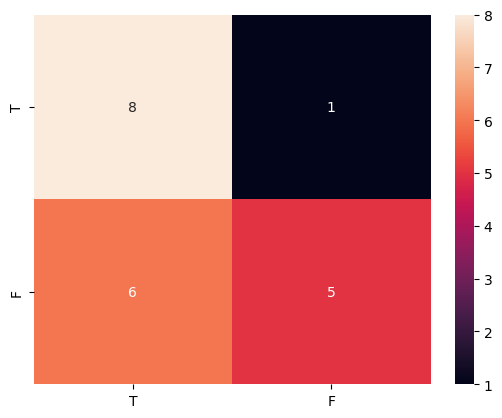

In [228]:
sn.heatmap(matrix, annot=True, xticklabels=['T', 'F'], yticklabels=['T', 'F'])

### 高斯貝氏分類器 GaussianNB
### 高斯分類器主要用於特徵為連續變數時，例如鳶尾花的花瓣、花萼特徵長度及寬度為幾公分、重量為幾公斤等等。在這個模型下，假設特徵資料服從常態分配。

In [229]:
from sklearn import datasets

In [236]:
iris=datasets.load_iris()
X=iris.data
y=iris.target

In [237]:
# 將資料拆分成訓練集與測試集 7:3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [240]:
# 模型建立與分析 (使用高斯貝氏分類器 Gaussian Naive Bayes)
model_G = GaussianNB().fit(X_train, y_train)
model_G.score(X_test, y_test)

1.0

In [242]:
model_G.predict(X_test)

array([2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1,
       0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 1, 1, 1, 2, 0, 2, 0,
       0])

In [243]:
# 可以透過predict_proba()來看每個樣本在各個類別下發生的機率。
model_G.predict_proba(X_test)

array([[2.44049291e-261, 1.75690913e-006, 9.99998243e-001],
       [4.62772960e-087, 9.99997509e-001, 2.49062165e-006],
       [1.00000000e+000, 5.86573779e-018, 8.16162532e-027],
       [2.96439388e-323, 1.10744521e-006, 9.99998893e-001],
       [1.00000000e+000, 3.17267813e-016, 5.32610050e-026],
       [0.00000000e+000, 1.46019193e-010, 1.00000000e+000],
       [1.00000000e+000, 4.31839423e-016, 7.65911289e-026],
       [8.09217628e-158, 7.80399392e-001, 2.19600608e-001],
       [7.24579939e-160, 9.08267456e-001, 9.17325438e-002],
       [8.90967866e-101, 9.99849842e-001, 1.50157614e-004],
       [1.04517663e-220, 4.70717779e-001, 5.29282221e-001],
       [8.85444946e-143, 9.41915811e-001, 5.80841887e-002],
       [3.77596535e-139, 9.98630652e-001, 1.36934795e-003],
       [1.30323456e-150, 9.46178914e-001, 5.38210855e-002],
       [1.08449063e-149, 9.85985808e-001, 1.40141923e-002],
       [1.00000000e+000, 3.83418804e-018, 7.85663405e-028],
       [7.01016623e-142, 9.85419351e-001

### 伯努力貝氏分類器主要適用於二元的特徵，比方說特徵是否出現、特徵大小、特徵長短等等這種二元的分類。若使用錯誤，預測效果就非常不佳。

In [247]:
# 例如錯誤模型建立與分析 (使用伯努力貝氏分類器 Bernoulli Naive Bayes)
# 將資料拆分成訓練集與測試集 7:3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model_B = BernoulliNB().fit(X_train, y_train)
model_B.score(X_test, y_test)

0.28888888888888886

In [248]:
model_B.predict(X_test)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2])

In [249]:
# 可以透過predict_proba()來看每個樣本在各個類別下發生的機率。
model_B.predict_proba(X_test)

array([[0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.34384738, 0.30177328, 0.35437934],
       [0.

### 多項式貝氏分類器 MultinomialNB
多項式貝氏分類器主要用在離散變數，比方說次數、類別等等。而在個模型中，會多一個參數，也就是平滑化的處理。

In [251]:
# 模型建立與分析 (使用多項式貝氏分類器 Multinomial Naive Bayes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)
model_M = MultinomialNB().fit(X_train, y_train)
model_M.score(X_test, y_test)

0.9111111111111111

In [252]:
model_M.predict(X_test)

array([0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 1, 2, 1,
       2, 1, 1, 0, 0, 2, 0, 2, 2, 0, 1, 2, 2, 0, 2, 1, 2, 2, 2, 1, 2, 1,
       0])

In [254]:
# 可以透過predict_proba()來看每個樣本在各個類別下發生的機率。
model_M.predict_proba(X_test)

array([[0.67583928, 0.20167572, 0.122485  ],
       [0.64830476, 0.21739671, 0.13429853],
       [0.00871369, 0.43639946, 0.55488685],
       [0.6906429 , 0.1940111 , 0.115346  ],
       [0.62803437, 0.231269  , 0.14069663],
       [0.01507903, 0.48435685, 0.50056411],
       [0.6348813 , 0.22678157, 0.13833713],
       [0.00759853, 0.45210532, 0.54029615],
       [0.00662621, 0.44070242, 0.55267137],
       [0.63009249, 0.22767337, 0.14223414],
       [0.7523428 , 0.16016276, 0.08749444],
       [0.68713212, 0.19428119, 0.11858669],
       [0.72755734, 0.17279987, 0.09964279],
       [0.69586704, 0.19414795, 0.10998501],
       [0.04050419, 0.4858518 , 0.47364401],
       [0.03319722, 0.48714019, 0.4796626 ],
       [0.53146029, 0.27793112, 0.1906086 ],
       [0.05280615, 0.48441374, 0.46278011],
       [0.00510739, 0.43451783, 0.56037478],
       [0.04658522, 0.47724277, 0.47617201],
       [0.02197035, 0.48171808, 0.49631157],
       [0.05622457, 0.49395417, 0.44982126],
       [0.